# U-Net Semi-supervised Baseline

### There are a lot parts to this notebook:

1) Import the data (in this case, just the 12 images with labels for buildings)

2) Setup and train a U-Net baseline model to make sure we can learn

3) Setup and train a U-Net autoencoder to make sure it can learn (only difference from U-net in part 2 will be the output layer)

4) Setup a U-Net that looks just like the first one we used in part 2, but loads in the pre-trained weights from the autoencoder

5) Finetune the final U-Net and see if it performs better than the baseline from part 2
    - We need to try different methods of finetuning:
    
        1) Just fine-tune the last layer
        2) Fine-tune the last couple layers
        3) Use the autoencoder weights and an initialization and re-train all layers
        4) Fine-tune the last layer and the first layer?
        
6) We need to try the following as well:

    1) Train the autoencoder with more images than just the 12 we have labels for
    2) Train the autoencoder for longer, until the reconstructions look better
    3) Train the final U-Net for longer
    
7) Once we get something working, we should throw in images we got from Planet into the dataset used to train the autoencoder, then finetune the model (per best method we find) on the images with labels, then test on planet images and see what happens -> Once we can get some decent results here I think we are done 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cv2
import shapely
import os
import tifffile as tif


In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# 1)
## A. - Explore the meta data a bit
The GeoJson polygons (the label masks) are stored in what is called WKT format in a csv file, we can load this in with pandas. I already converted all of the polygons to TIFF files and saved them in the 'labels' directory, so this section is purely for seeing stuff about the data

Note: To do this conversion, you have to convert the polygon sizes to Raster (See Appendix A, or the Kaggle page: https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection#data-processing-tutorial

In [3]:
wkt_df = pd.read_csv('../../data/dstl_data/train_wkt_v4.csv')
print("There are {} images with labeled polygon masks".format(wkt_df.shape[0]//10))
wkt_df.head()

There are 25 images with labeled polygon masks


,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


In [4]:
# These are the class number mappings
CLASSES = {
    1 : 'Bldg',
    2 : 'Struct',
    3 : 'Road',
    4 : 'Track',
    5 : 'Trees',
    6 : 'Crops',
    7 : 'Fast H20',
    8 : 'Slow H20',
    9 : 'Truck', # Don't think we care about these
    10 : 'Car' # Don't think we care about these
}

# How many images for each class?
class_counts = wkt_df[wkt_df['MultipolygonWKT'] != 'MULTIPOLYGON EMPTY'].groupby('ClassType')
print(class_counts['ImageId'].count())

ClassType
1     12
2     17
3     11
4     23
5     25
6     14
7      2
8     13
9      8
10    13
Name: ImageId, dtype: int64


#### .: For class 1 ('buildings') there are only 12 images with label masks

## B. - Setup some helper functions

In [5]:
# Helper function to filter for images that have the labels we want
def find_images_with_mask(wkt_df, desired_class, empty_wkt_val='MULTIPOLYGON EMPTY'):
    '''
    Function to find all images that have masks for a certain class.
    Returns a list of the image ids
    
    Input: wkt_df -- Pandas DataFrame; DF containing the image_ids, class types and WKT data
           desired_class -- Int; Desired class to get images for
           empty_wkt_val -- String, or np.nan; A value for an empty value in the WKT column of the dataframe
    Output: set; Set containing the image filenames that have all the masks corresponding to the desired class
           
    '''
    image_ids = set()
    for row in wkt_df.itertuples():
        image_id = row[1]
        class_id = row[2]
        wkt_val = row[3]
        
        if class_id == desired_class and wkt_val != empty_wkt_val:
            
            image_ids.add(image_id)

    return image_ids

# Test the function quickly to make sure we find the correct image ids for class 1
image_ids = find_images_with_mask(wkt_df, desired_class=1)
assert len(image_ids) == 12

In [6]:
# Loads only the RGB-N bands of a Worldview 3 image
def load_img_rgbn(img_id, path):
    # Load image - need transpose at the end to get the image in NxHxWxC format
    img_rgbn = tif.imread(os.path.join(path,'sixteen_band', img_id + '_M.tif')).transpose((1, 2, 0))
    
    # Get only the B,G,R,NIR bands (in that order) - There are 8 bands in each image
    img_rgbn = np.take(img_rgbn, [1, 2, 4, 6], axis=2)
    
    # Reshape bands so in order of R,G,B,NIR
    img_rgbn = img_rgbn[..., [2, 1, 0, 3]]
    return img_rgbn

# Loads only the RGB bands of a Worldview 3 image
def load_img_rgb(img_id, path):
    # Load image - need transpose at the end to get the image in NxHxWxC format
    img_rgb = tif.imread(os.path.join(path,'sixteen_band', img_id + '_M.tif')).transpose((1, 2, 0))
    
    # Get only the B,G,R bands (in that order) - There are 8 bands in each image
    img_rgb = np.take(img_rgb, [1, 2, 4], axis=2)
    
    # Reshape bands so in order of R,G,B
    img_rgb = img_rgb[..., [2, 1, 0]]
    return img_rgb

# Loads the label mask tiff images saved in the 'labels' directory
def load_labels(image_id, size, class_id, path):
    label_file_name = image_id + '_' + str(size) + '_class_' + str(class_id) + '.tif'
    return tif.imread(os.path.join(path, 'labels', label_file_name))

## C. - Load in the data
#### Note:
For Worldview 3 images, the band order for the 8 band images we have is the following:

Coastal, Blue, Green, Yellow, Red, Red Edge, NIR1, NIR2 

We want Blue(index=1), Green(2), Red(4), NIR1(6)

See helper functions above

In [7]:
def get_data_and_labels_for_class(wkt_df, class_id, img_ids, path, end_img_size=(835, 835, 4)):
    '''
    Function to import all images that have label masks for a particular class 
    Inputs: wkt_df -- dataframe; Dataframe containing the wkt_csv 
            class_id -- int; The class id we want to load the data for (ex: 1 for 'Buildings')
            img_ids -- set; The output from the other helper function find_images_with_mask
            path -- string; The high level path containing the 'labels' and 'sixteen_bands' directories
            end_img_sze -- tuple; Desired size of the final images to be resized to
    Outputs: images -- numpy array; Array containing image files
             labels -- numpy array; Array containing the image label masks
    '''
    # Preallocate array to store images in
    img_H = end_img_size[0]
    img_W = end_img_size[1]
    img_C = end_img_size[2] 
    N = len(img_ids) # Number of images
    images = np.zeros((N, img_H, img_W, img_C), dtype=np.float32)
    
    labels = np.zeros((N, img_H, img_W, 1), dtype=np.float32)
    for ix, img_id in enumerate(img_ids):
        # Load the image based on it's id and the path
        img_rgb = load_img_rgb(img_id, path) 
        
        # Normalize the pixel values to be floats in range [0,1]
        # The max pixel value is 2048, so divide by the max
        img_rgb = img_rgb / 2048.0

        # Resize the image to be of specified size and Store the image in the preallocated array
        images[ix, :, :, :] = cv2.resize(img_rgb, (img_H, img_W), interpolation=0)
         
        # Load the class mask for the image
        larger_mask =  load_labels(img_id, 835, class_id, path)
        resized_mask = cv2.resize(larger_mask, (img_H, img_W), interpolation=0).reshape(img_H, img_W, 1)
        labels[ix, :, :, :] = resized_mask
    
    return images, labels

### Actually load in some data

If you play around with the CLASS param, and run the next three cells, you can see what the different classes look like

In [8]:
# Actually load in some data
# Lets look at the images containing the 'Building' class

TOP_PATH = '../../data/dstl_data/'


NUM_CHANNELS = 3 # Set to 4 if using NIR band

# Note: I had to change the end_image_size to 256 because the U-Net wasn't working with size 835
# --> We need to tile the 835 images into 256 images or smaller
END_IMAGE_SIZE = 256

# Which class?
# CLASSES = {
#     1 : 'Bldg',
#     2 : 'Struct',
#     3 : 'Road',
#     4 : 'Track',
#     5 : 'Trees',
#     6 : 'Crops',
#     7 : 'Fast H20',
#     8 : 'Slow H20',
#     9 : 'Truck', 
#     10 : 'Car' 
# }

CLASS = 1

img_ids = find_images_with_mask(wkt_df, desired_class=CLASS)
x_full, y_full = get_data_and_labels_for_class(wkt_df=wkt_df, 
                                              class_id=CLASS, 
                                              img_ids=img_ids, 
                                              path=TOP_PATH, 
                                              end_img_size=(END_IMAGE_SIZE , END_IMAGE_SIZE, NUM_CHANNELS))

print(x_full.shape)
print(y_full.shape)


(12, 256, 256, 3)
(12, 256, 256, 1)


#### Lets visualize some of the data now

 -- Note with the downsampled sizes of 256x256 we lose data

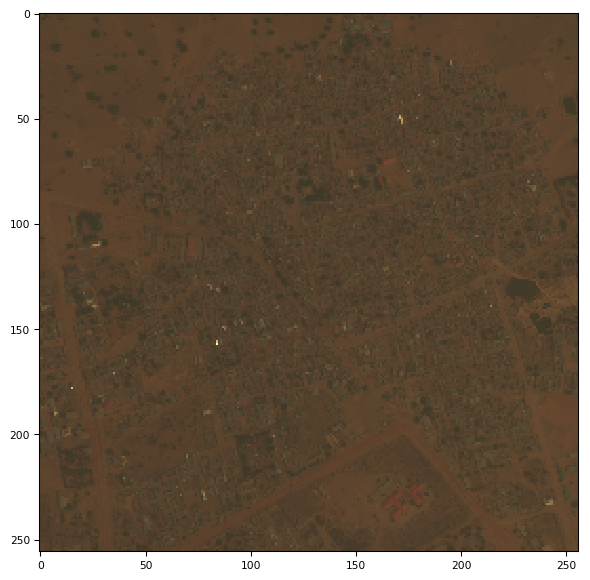

In [9]:
# Visualize an image using the tifffile library (much more light weight than rasterio - no GDAL required)
IMG_TO_VIS = 0
tif.imshow(x_full[IMG_TO_VIS, :, :, :])
plt.show()

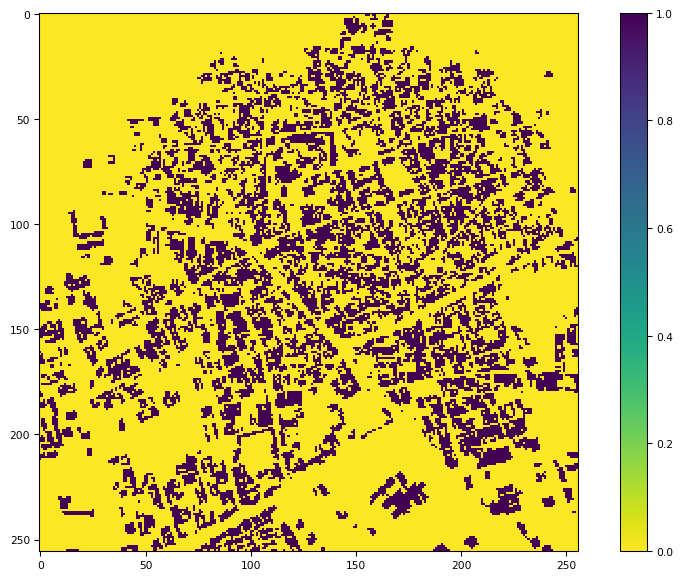

In [10]:
# Visualize a mask using the tifffile library (much more light weight than rasterio)
tif.imshow(y_full[IMG_TO_VIS, :, :, :])
plt.show()

# 2) - Setup Model and Run U-Net Segmentation Baseline

#### Split into train/valid

In [11]:
TRAIN_SPLIT = 0.8

NUM_TRAIN = int(np.ceil(x_full.shape[0] * TRAIN_SPLIT))
x_train, x_valid = x_full[:NUM_TRAIN, ...].copy(), x_full[NUM_TRAIN:, ...].copy()
y_train, y_valid = y_full[:NUM_TRAIN, ...].copy(), y_full[NUM_TRAIN:, ...].copy()


print("Y Train Shape: ", y_train.shape)
print("X Train Shape: ", x_train.shape)
print("X Validation Shape: ", x_valid.shape)
print("Y Validation Shape: ", y_valid.shape)

Y Train Shape:  (10, 256, 256, 1)
X Train Shape:  (10, 256, 256, 3)
X Validation Shape:  (2, 256, 256, 3)
Y Validation Shape:  (2, 256, 256, 1)


In [12]:
# Get a sample of two images to check overfitting - if needed
x_sample = x_train[:2, ...]
y_sample = y_train[:2, ...]

print(x_sample.shape, y_sample.shape)

(2, 256, 256, 3) (2, 256, 256, 1)


#### Setup the loss functions, metrics and model

In [16]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Cropping2D, ELU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### We need to decide on the correct metrics to evaluate the model:
- Perhaps we just monitor them all; I think the best method of evaluation is looking at the predicted masks

#### For the DSTL competition, the metric of Jaccard coefficient was used:
The Jaccard coefficient is a common method of measuring the effectivness of a segmentation algorithm:
$$Jaccard = {\frac{TP}{TP+FP+FN} }= {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}$$

See -- https://en.wikipedia.org/wiki/Jaccard_index

#### If we use the jaccard coefficient, there is a jaccard distance loss function I found from this location: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py

#### For another more recent segmentation competition on Kaggle (https://www.kaggle.com/c/data-science-bowl-2018#evaluation) the Mean IoU metric was used.
- See that link for a description


In [17]:
def jaccard_coef(y_true, y_pred, smooth=1e-12):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

In [18]:
def U_Net_Seg_Baseline(img_shape):
    
    inputs = Input(img_shape)
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    
    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    
    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = Conv2DTranspose(128, 2, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = Conv2DTranspose(32, 2, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(conv9)
    conv9 = BatchNormalization()(conv9) 
    conv9 = ELU()(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, 
                  outputs=conv10)
    return model

### Train the baseline U-Net segmentation model

- Monitor loss -> check validation loss, once it starts diverging we are overfitting
- The jaccard_coef should get larger
- mean_iou should also get larger
- accuracy isn't that important, but look at it anyway

In [44]:
# Setup the model
model_seg_baseline = U_Net_Seg_Baseline(img_shape=x_train.shape[1:])

model_seg_baseline.compile(optimizer='adam', 
                          loss='binary_crossentropy', 
                          metrics=['accuracy', 
                                   jaccard_coef, 
                                   mean_iou])

model_seg_baseline.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 256, 256, 32) 128         conv2d_78[0][0]                  
__________________________________________________________________________________________________
elu_73 (ELU)                    (None, 256, 256, 32) 0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_79 

In [32]:
# Train
SAMPLE = False
if (SAMPLE):
    # For sample set - 2 images to test for overfitting
    print("Using sample data to check model is learning")
    model_seg_baseline.fit(x_sample, y_sample, 
                          batch_size=2, 
                          epochs=10, 
                          verbose=1, 
                          shuffle=True, 
                          validation_data=(x_sample, y_sample))
else:
    # For full train set
    model_seg_baseline.fit(x_train, y_train, 
                          batch_size=10, 
                          epochs=10, 
                          verbose=1, 
                          shuffle=True, 
                          validation_data=(x_valid, y_valid))

Train on 10 samples, validate on 2 samples
Epoch 1/10
10/10 [==============================] - 39s 4s/step - loss: 0.7375 - acc: 0.5386 - jaccard_coef: 0.0807 - mean_iou: 0.0000e+00 - val_loss: 1.4058 - val_acc: 0.2640 - val_jaccard_coef: 0.0457 - val_mean_iou: 0.4098
Epoch 2/10
10/10 [==============================] - 32s 3s/step - loss: 0.7398 - acc: 0.5637 - jaccard_coef: 0.1031 - mean_iou: 0.3895 - val_loss: 0.6695 - val_acc: 0.6274 - val_jaccard_coef: 0.0602 - val_mean_iou: 0.4016
Epoch 3/10
10/10 [==============================] - 34s 3s/step - loss: 0.6408 - acc: 0.6360 - jaccard_coef: 0.1087 - mean_iou: 0.4060 - val_loss: 0.5254 - val_acc: 0.7375 - val_jaccard_coef: 0.0736 - val_mean_iou: 0.4196
Epoch 4/10
10/10 [==============================] - 30s 3s/step - loss: 0.5990 - acc: 0.7081 - jaccard_coef: 0.1162 - mean_iou: 0.4229 - val_loss: 1.0897 - val_acc: 0.2999 - val_jaccard_coef: 0.0577 - val_mean_iou: 0.4342
Epoch 5/10
10/10 [==============================] - 28s 3s/step -

## Look at the predicted masks on train and validation data to see if it's working

In [34]:
def plot_predictions(x_data, y_data, model, img_index=0, CUTOFF=0.5):
    predicted_masks = model.predict(x_data)

    tif.imshow(x_data[img_index, :, :, :])
    tif.imshow(y_data[img_index, :, :, :])
    tif.imshow(predicted_masks[img_index, :, :, :] > CUTOFF)
    
    plt.show()

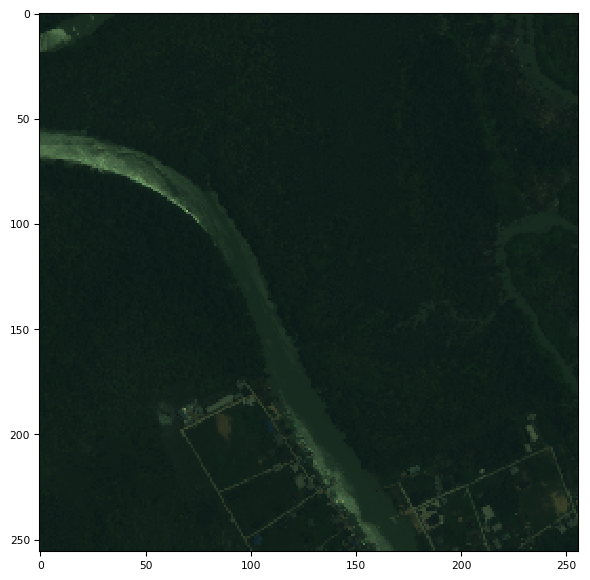

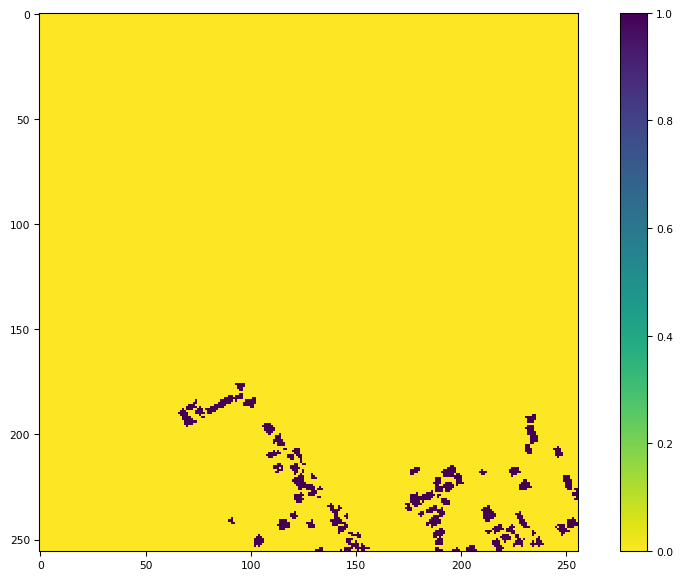

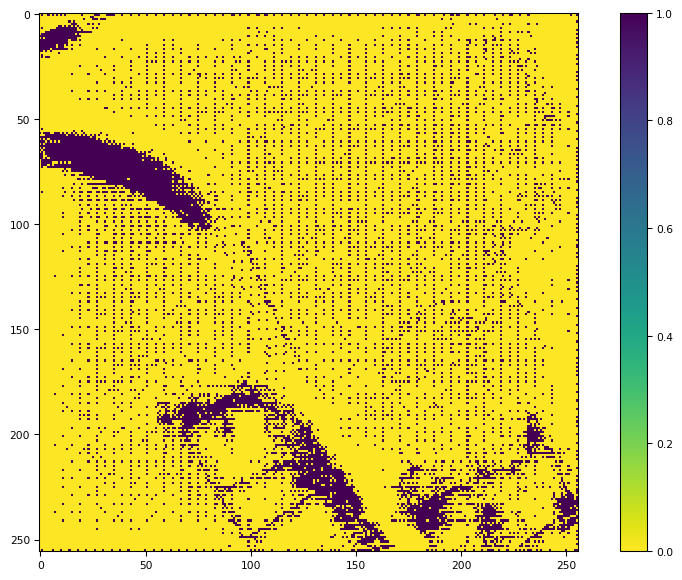

In [36]:
# Plot predictions on training data
plot_predictions(x_train, y_train, model_seg_baseline, img_index=2)

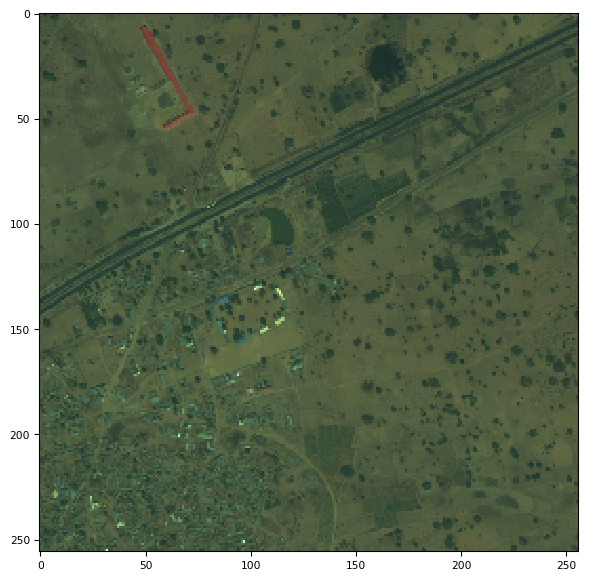

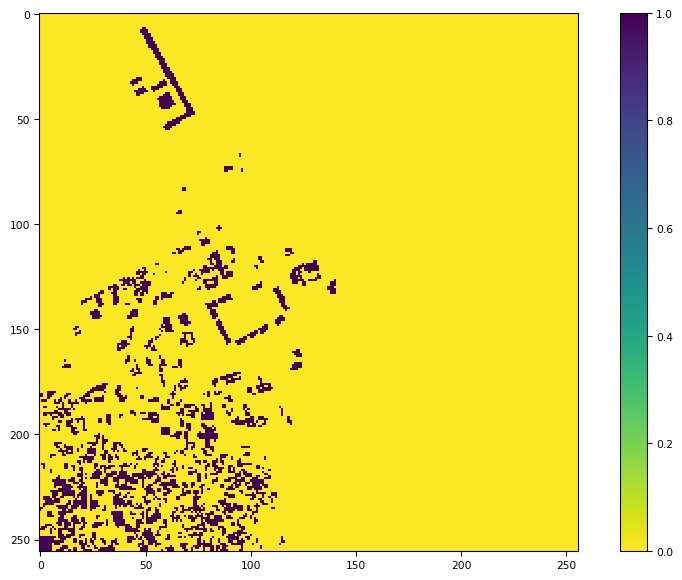

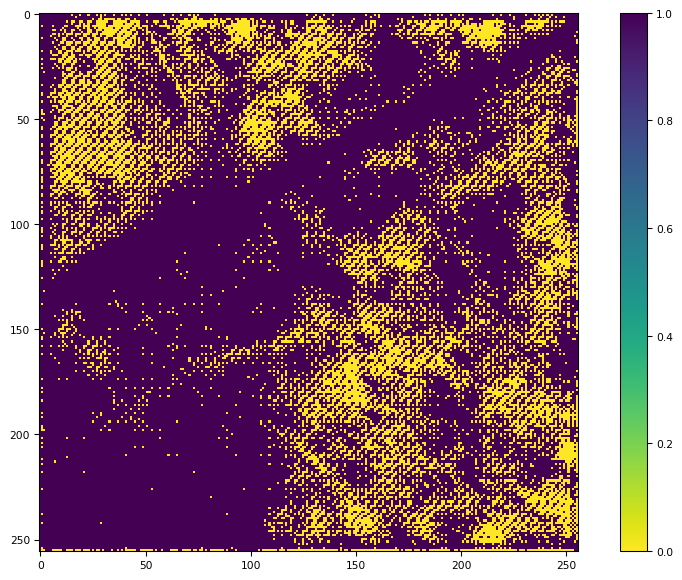

In [26]:
# Plot first validation image
plot_predictions(x_valid, y_valid, model_seg_baseline, img_index=0)

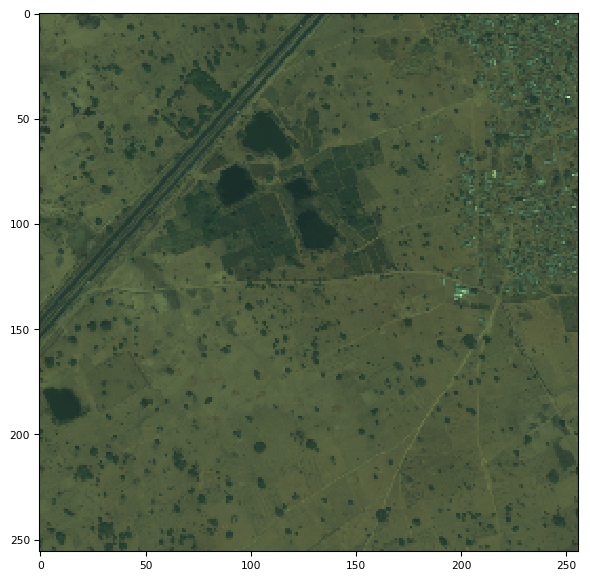

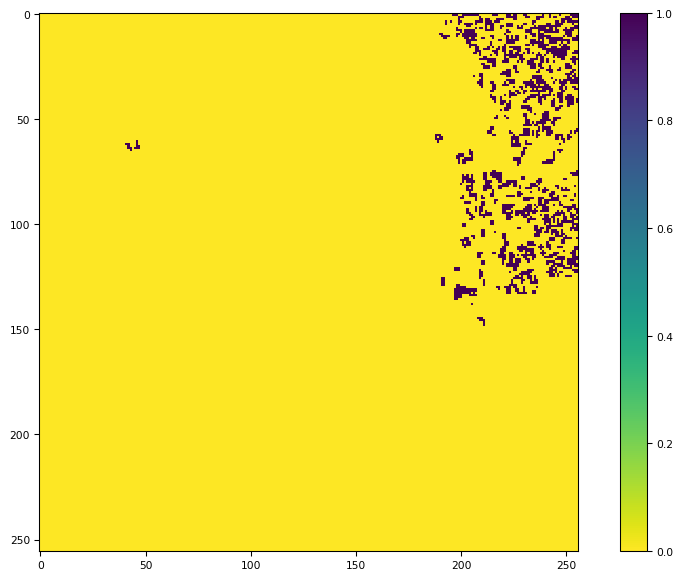

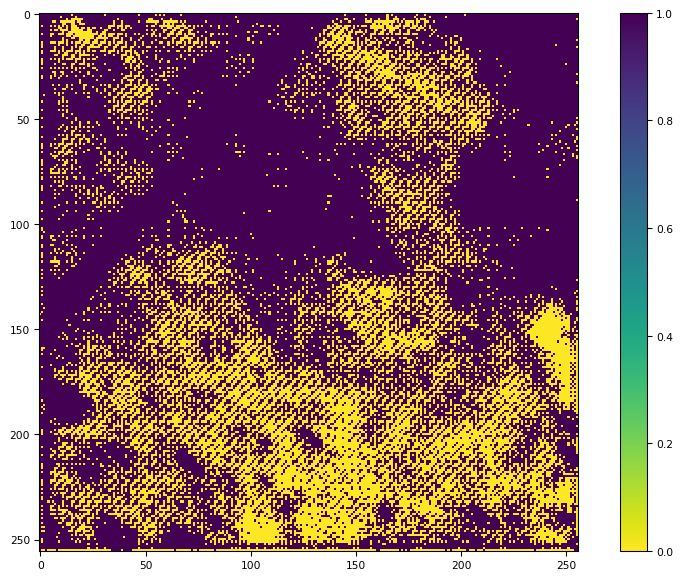

In [27]:
# Plot second validation image
plot_predictions(x_valid, y_valid, model_seg_baseline, img_index=1)

### Conclusions:
- We appear to be overfitting - perhaps we should add dropout the the U-Net model after conv layers
- I noticed in my experiments that the results of this model are heavily dependant on which images get randomly put into the training data set

# 3) Train the autoencoder

- For this, monitor the loss only, accuracy isn't relevant

In [45]:
def U_Net_AutoEncoder(img_shape):
    
    inputs = Input(img_shape)
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    
    conv2 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    
    conv3 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    conv4 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    
    conv5 = Conv2D(512, 3, padding='same', kernel_initializer='he_uniform')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    
    conv6 = Conv2D(256, 3, padding='same', kernel_initializer='he_uniform')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = Conv2DTranspose(128, 2, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    
    conv7 = Conv2D(128, 3, padding='same', kernel_initializer='he_uniform')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    
    conv8 = Conv2D(64, 3, padding='same', kernel_initializer='he_uniform')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = Conv2DTranspose(32, 2, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    
    conv9 = Conv2D(32, 3, padding='same', kernel_initializer='he_uniform')(conv9)
    conv9 = BatchNormalization()(conv9) 
    conv9 = ELU()(conv9)
    
    # Note the differences in output layer: 3 channels instead of 1
    # Linear activation or sigmoid? I think sigmoid because we regularize the pixels to be between 0-1
    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9) 

    model = Model(inputs=inputs, 
                  outputs=conv10)

    return model

In [46]:
model_ae = U_Net_AutoEncoder(img_shape=x_train.shape[1:])

model_ae.compile(optimizer=Adam(lr=1e-3), 
                 # Use the MSE loss function for the autoencoder
                 loss='mse', 
                 metrics=['accuracy'])

model_ae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 256, 256, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_92 (BatchNo (None, 256, 256, 32) 128         conv2d_97[0][0]                  
__________________________________________________________________________________________________
elu_91 (ELU)                    (None, 256, 256, 32) 0           batch_normalization_92[0][0]     
__________________________________________________________________________________________________
conv2d_98 

In [47]:
SAMPLE = False

if (SAMPLE):
    # For sample set
    print("Using sample data to check model is learning")
    model_ae.fit(x_sample, x_sample, 
                      batch_size=2, 
                      epochs=15, 
                      verbose=1, 
                      shuffle=True, 
                      validation_data=(x_sample, x_sample))
else:
    # For full train set
    model_ae.fit(x_train, x_train, 
                      batch_size=8, 
                      epochs=15, 
                      verbose=1, 
                      shuffle=True, 
                      validation_data=(x_valid, x_valid))

Train on 10 samples, validate on 2 samples
Epoch 1/15
10/10 [==============================] - 40s 4s/step - loss: 0.1558 - acc: 0.2915 - val_loss: 0.3208 - val_acc: 0.8117
Epoch 2/15
10/10 [==============================] - 33s 3s/step - loss: 0.1370 - acc: 0.3179 - val_loss: 0.2382 - val_acc: 0.4051
Epoch 3/15
10/10 [==============================] - 38s 4s/step - loss: 0.1222 - acc: 0.5123 - val_loss: 0.2987 - val_acc: 0.1532
Epoch 4/15
10/10 [==============================] - 29s 3s/step - loss: 0.1108 - acc: 0.5067 - val_loss: 0.3390 - val_acc: 0.1861
Epoch 5/15
10/10 [==============================] - 30s 3s/step - loss: 0.1041 - acc: 0.4705 - val_loss: 0.3404 - val_acc: 0.2600
Epoch 6/15
10/10 [==============================] - 28s 3s/step - loss: 0.0991 - acc: 0.3610 - val_loss: 0.3433 - val_acc: 0.3093
Epoch 7/15
10/10 [==============================] - 28s 3s/step - loss: 0.0952 - acc: 0.4238 - val_loss: 0.3508 - val_acc: 0.3257
Epoch 8/15
10/10 [=============================

### Save the weights to be used in the segmentation model 

In [48]:

# TO DO: Change this version number to automatically use a time-stamp so we don't have to remember to change it
# for different experiments
version = 1
save_path = './weights/autoencoder_weights_v{}.h5'.format(version)

# Save the model weights
model_ae.save(save_path)

In [54]:
def plot_reconstructions(x_data, y_data, model, img_index=0):
    predicted_masks = model.predict(x_data)
    
    print("First image is the original, second is the reconstructed image")
    tif.imshow(x_data[img_index, :, :, :])
    
    tif.imshow(predicted_masks[img_index, :, :, :] / np.amax(predicted_masks))
    
    plt.show()

First image is the original, second is the reconstructed image


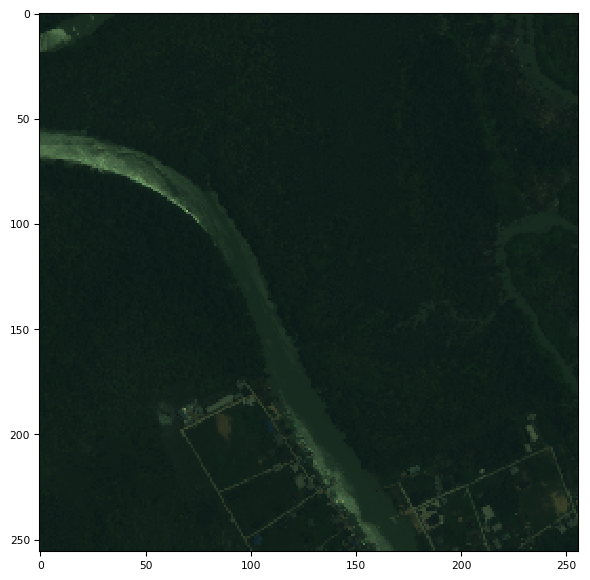

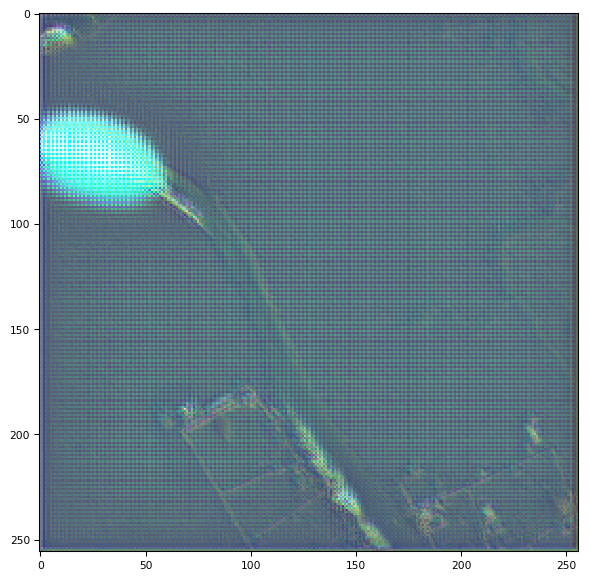

In [55]:
# Try plotting predictions on training data
plot_reconstructions(x_train, x_train, model_ae, img_index=2)

First image is the original, second is the reconstructed image


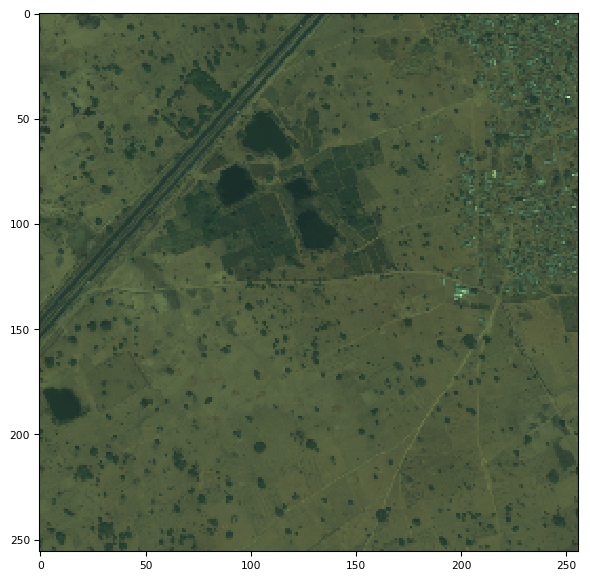

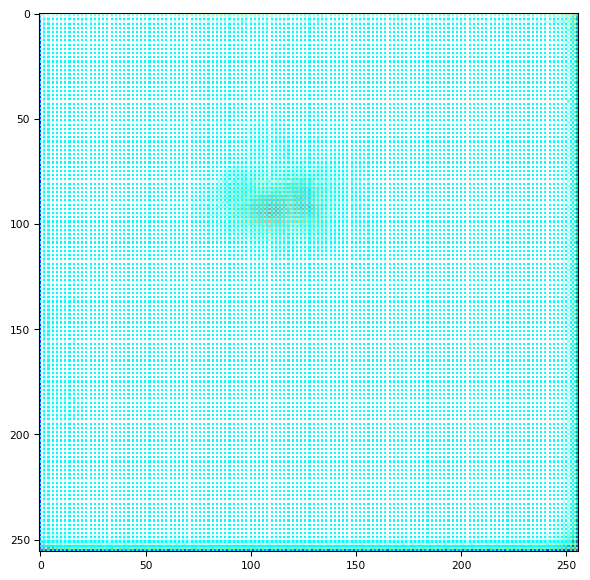

In [57]:
plot_reconstructions(x_valid, y_valid, model_ae, img_index=1)

### Conclusions:
- Not sure if we are overfitting on this one, or if we need to train for longer

## I ran an experiment trying out linear activation instead of sigmoid in the last layer, the results look different, and I think less good:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


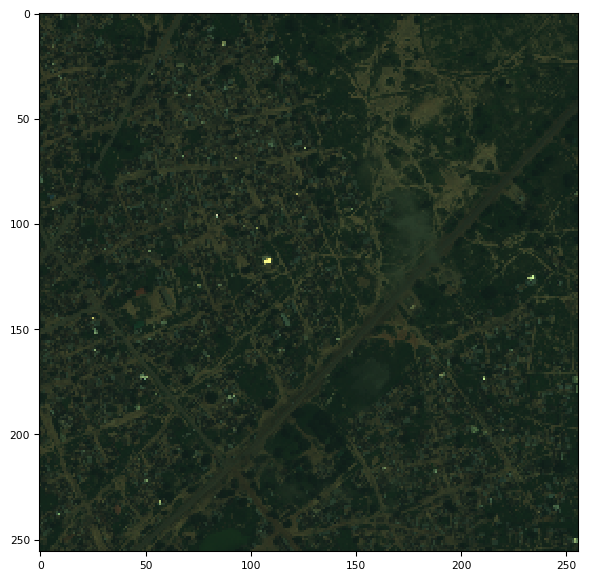

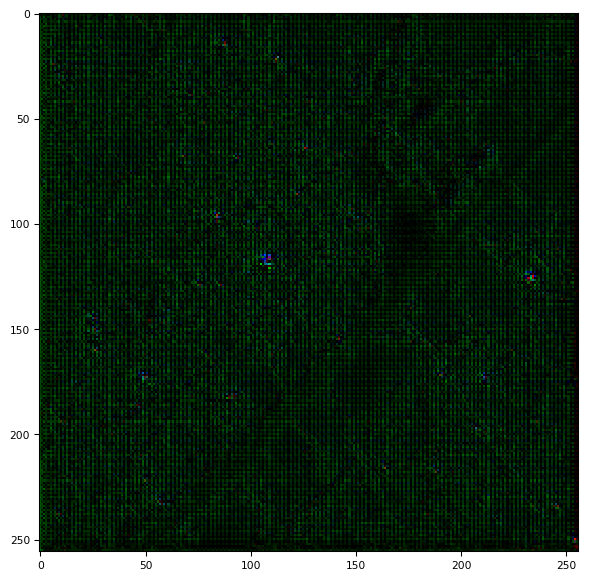

In [54]:
# An example of results from using a linear activation function at the output
plot_reconstructions(x_valid, y_valid, model_ae)

# 4) Setup segmentation model now to use weights from Autoencoder

In [59]:
def U_Net_Seg_Transfer(base_model, base_model_weights_path):
    
    # Load the weights from the autoencoder 
    base_model.load_weights(base_model_weights_path, by_name=True)
    
    # Get the output of the layer before the last conv layer
    out_base = base_model.layers[-1].output
    
    # Add on the last conv layer for segmentation
    conv_last = Conv2D(1, 1, activation='sigmoid')(out_base)
    
    # Define the inputs and outputs
    model = Model(inputs=base_model.inputs, 
                  outputs=conv_last)

    return model

# 5) Fine-tune
### Run the transfer learning

- In this example I am training the last 6 layers (see two cells below)
- I tried training only the last layer that we added and this did not work (but I only ran it for 15 epochs, so it could be I needed to run it longer)
- We need to try training more layers, or re-train all the layers (just use the pre-training as an initialization)

In [65]:
# Pass in the path we saved the weights file too as well as the model
model_segmentation = U_Net_Seg_Transfer(model_ae, save_path)

# Printout all the layer names and whether or not they are set to be trained 
for layer in model_segmentation.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x186b4e518> False
<keras.layers.convolutional.Conv2D object at 0x186b4e198> False
<keras.layers.normalization.BatchNormalization object at 0x186b3fd30> False
<keras.layers.advanced_activations.ELU object at 0x186b3f8d0> False
<keras.layers.convolutional.Conv2D object at 0x186b4e128> False
<keras.layers.normalization.BatchNormalization object at 0x186b8b550> False
<keras.layers.advanced_activations.ELU object at 0x186bcb160> False
<keras.layers.pooling.MaxPooling2D object at 0x184f0cf98> False
<keras.layers.convolutional.Conv2D object at 0x184f42b38> False
<keras.layers.normalization.BatchNormalization object at 0x185019f98> False
<keras.layers.advanced_activations.ELU object at 0x184fe6630> False
<keras.layers.convolutional.Conv2D object at 0x185033dd8> False
<keras.layers.normalization.BatchNormalization object at 0x185075908> False
<keras.layers.advanced_activations.ELU object at 0x185095080> False
<keras.layers.pooling.MaxPooling2D object

In [66]:
# When we load in the weights, those layers get set to False (will not be trained)
# We need to change this if we wish to train them


# Set the last 6 layers to be trained
# -> can see how many layers there are by using: len(model_segmentation.layers)

for layer in model_segmentation.layers[-6:]:
        layer.trainable = True
        


In [67]:
model_segmentation.compile(optimizer='adam', 
                          loss='binary_crossentropy', 
                          metrics=['accuracy', 
                               jaccard_coef, 
                               mean_iou])


        
model_segmentation.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 256, 256, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_92 (BatchNo (None, 256, 256, 32) 128         conv2d_97[0][0]                  
__________________________________________________________________________________________________
elu_91 (ELU)                    (None, 256, 256, 32) 0           batch_normalization_92[0][0]     
__________________________________________________________________________________________________
conv2d_98 

In [68]:
# Actually train

SAMPLE = False
if (SAMPLE):
    # For sample set
    print("Using sample data to check model is learning")
    model_segmentation.fit(x_sample, y_sample, 
              batch_size=2, 
              epochs=15, 
              verbose=1, 
              shuffle=True, 
              validation_data=(x_sample, y_sample))
else:
    # For full train set
    model_segmentation.fit(x_train, y_train, 
                          batch_size=10, 
                          epochs=15, 
                          verbose=1, 
                          shuffle=True, 
                          validation_data=(x_valid, y_valid))

Train on 10 samples, validate on 2 samples
Epoch 1/15
10/10 [==============================] - 18s 2s/step - loss: 0.7636 - acc: 0.0977 - jaccard_coef: 0.0900 - mean_iou: 0.0000e+00 - val_loss: 0.8531 - val_acc: 0.0454 - val_jaccard_coef: 0.0437 - val_mean_iou: 0.4091
Epoch 2/15
10/10 [==============================] - 12s 1s/step - loss: 0.7612 - acc: 0.0977 - jaccard_coef: 0.0901 - mean_iou: 0.4072 - val_loss: 0.8518 - val_acc: 0.0454 - val_jaccard_coef: 0.0437 - val_mean_iou: 0.4077
Epoch 3/15
10/10 [==============================] - 12s 1s/step - loss: 0.7593 - acc: 0.0977 - jaccard_coef: 0.0901 - mean_iou: 0.4069 - val_loss: 0.8506 - val_acc: 0.0454 - val_jaccard_coef: 0.0436 - val_mean_iou: 0.4072
Epoch 4/15
10/10 [==============================] - 12s 1s/step - loss: 0.7571 - acc: 0.0977 - jaccard_coef: 0.0901 - mean_iou: 0.4067 - val_loss: 0.8496 - val_acc: 0.0454 - val_jaccard_coef: 0.0436 - val_mean_iou: 0.4070
Epoch 5/15
10/10 [==============================] - 12s 1s/step -

### Plot the results like we did before

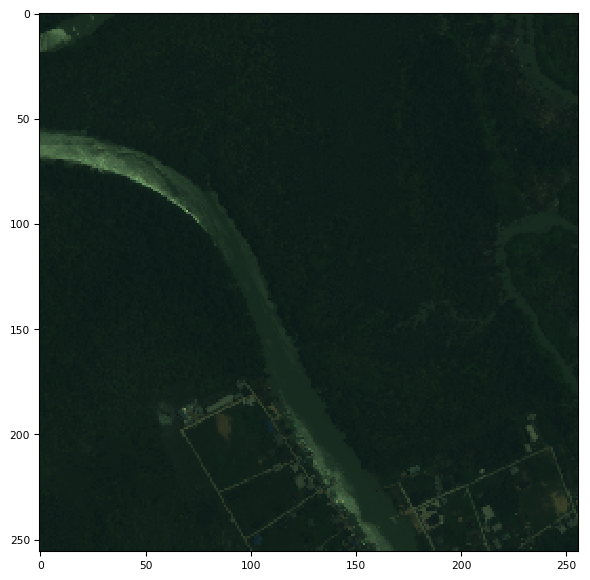

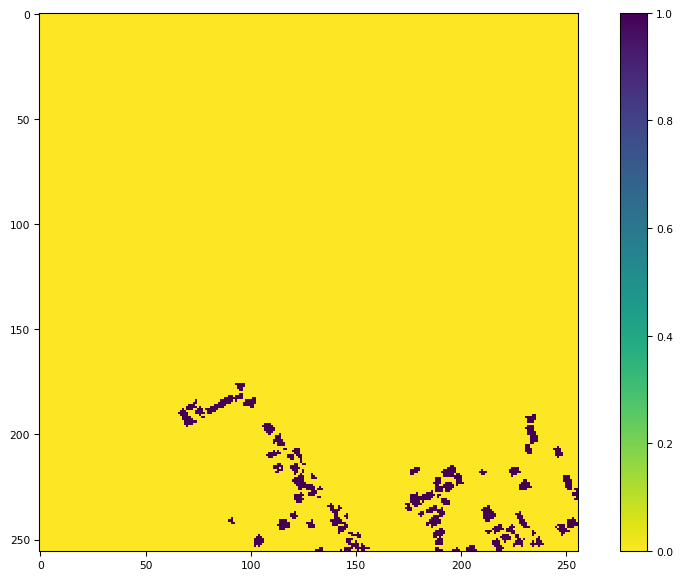

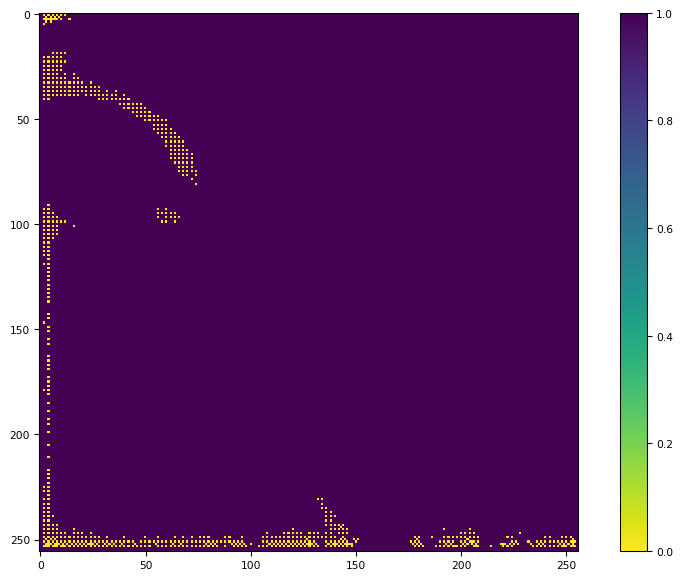

In [69]:
# Try plotting predictions on training data
plot_predictions(x_train, y_train, model_segmentation, img_index=2)

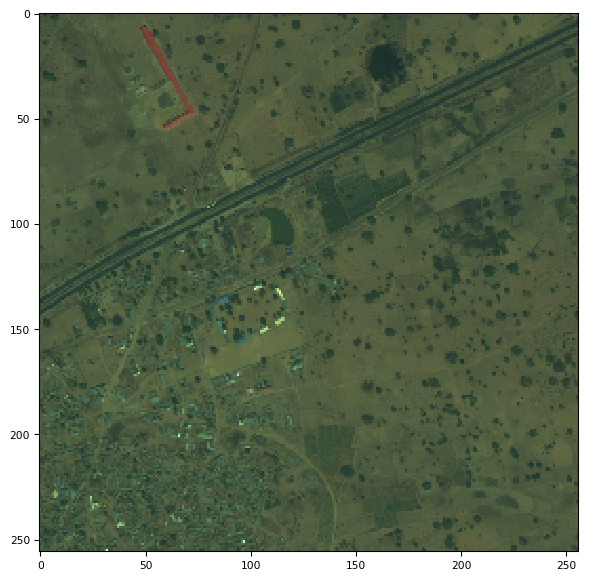

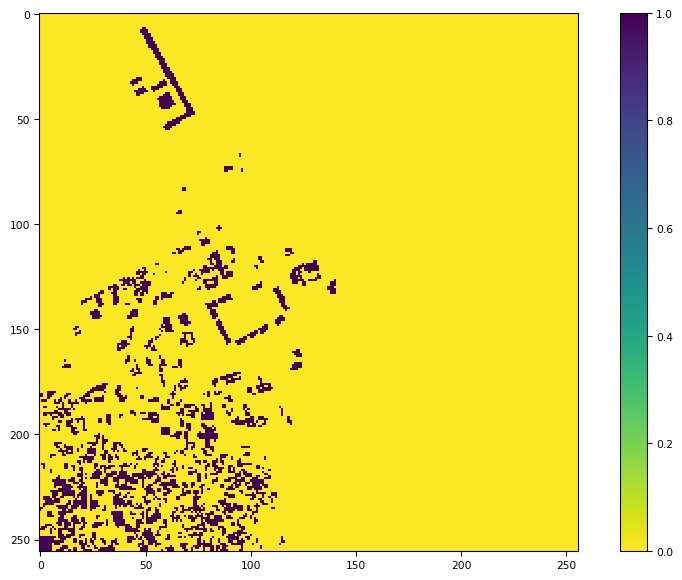

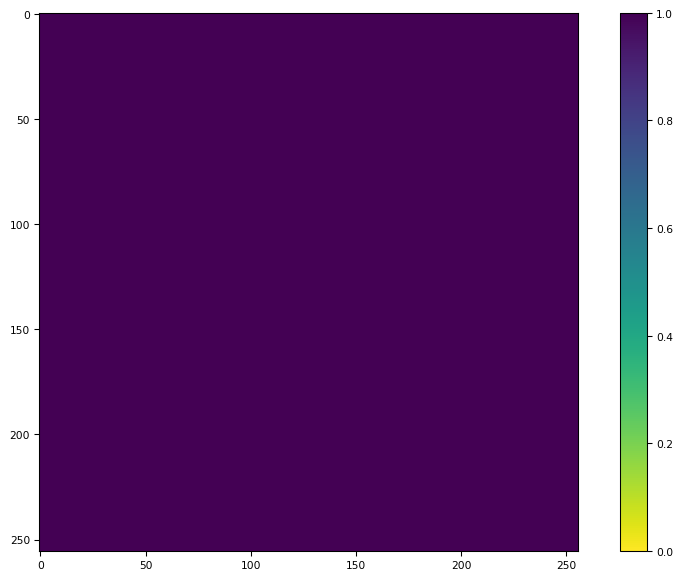

In [70]:
# Plot the first validation image
plot_predictions(x_valid, y_valid, model_segmentation, img_index=0)

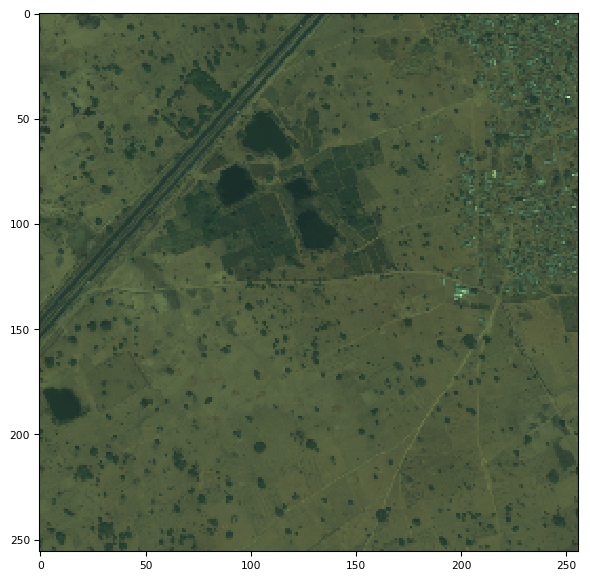

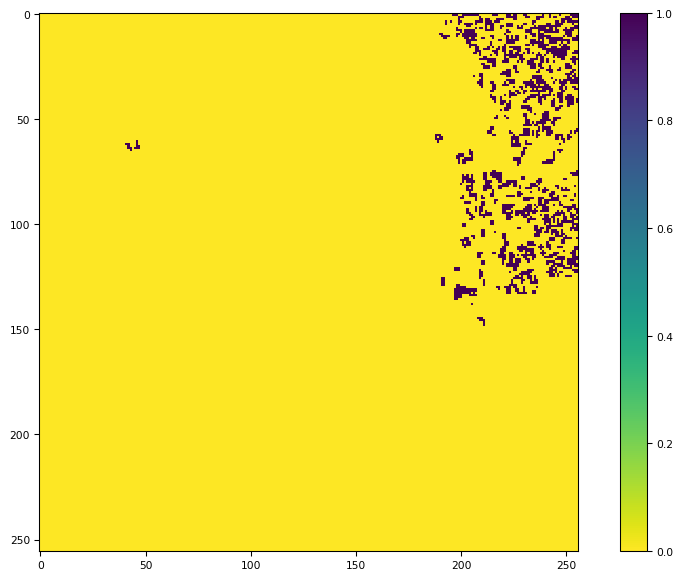

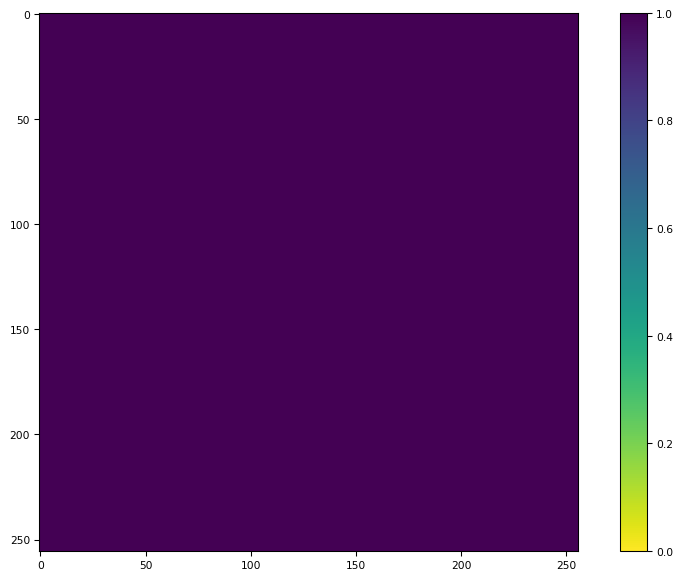

In [71]:
# Plot the second validation image
plot_predictions(x_valid, y_valid, model_segmentation, img_index=1)

## Conclusion

 1) The final fine-tuning is not working in it's current state - need to try finetuning different number of layers 
     - I'd try changing the -6 to -4 above 
     - I'd also try setting all the layers to trainable and see what happens
 

## Appendix A. - Info about converting the polygons to Raster images (tiff files)
#### The DSTL images have had their geo-coordinates normalized to hide the location the images were taken, as a result we need to use the below equations to get the correct Width and Height of each image:

$$W^\prime = W \cdot \frac{W} {W+1}$$
$$x^\prime = \frac{x}{x_{max}} \cdot W^\prime$$
$$H^\prime = H \cdot \frac{H}{H+1}$$
$$y^\prime = \frac{y}{y_{min}}\cdot H^\prime$$

The X_max and Y_min values are stored in the grid_sizes csv

This was done already, and the files were stored in the 'labels' directory

In [3]:
# Have a look at the grid_sizes if you desire
grid_sizes = pd.read_csv('../../data/dstl_images/grid_sizes.csv')
grid_sizes.rename(columns={'Unnamed: 0': 'ImageId'}, 
                  inplace=True)
print("There are {} images in total".format(grid_sizes.shape[0]))
grid_sizes.head()

There are 450 images in total


,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904
